In [1]:
import torch
from torch import nn
import torch.nn.functional as F

In [2]:
def init_seq2seq(module):
    if type(module) == nn.Linear:
        nn.init.xavier_uniform_(module.weight)
    elif type(module) == nn.GRU:
        for param in module._flat_weights_names:
            if 'weight' in param:
                nn.init.xavier_uniform_(module._parameters[param])

In [3]:
embedding = nn.Embedding(10, 3)
input = torch.LongTensor([[1, 2, 4, 5], [4, 3, 2, 9]])
print(input.shape)
embedding(input).shape

torch.Size([2, 4])


torch.Size([2, 4, 3])

In [4]:
from d2l_common import Encoder, Decoder


class Seq2SeqEncoder(Encoder):
    """The RNN encoder for sequence-to-sequence learning."""

    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0, device='cpu'):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding = nn.Embedding(vocab_size, embed_size).to(device)
        self.rnn = nn.GRU(embed_size, num_hiddens, num_layers, dropout=dropout).to(device)
        self.apply(init_seq2seq)

    def forward(self, X, *args):
        # X shape: (batch_size, num_steps)
        embs = self.embedding(X.T.type(torch.int64))
        # embs.shape = (num_steps, batch_size, embed_size)
        outputs, state = self.rnn(embs)
        # outputs.shape = (num_steps, batch_size, num_hiddens)
        # state.shape = (num_layers, batch_size, num_hiddens)
        return outputs, state

In [5]:
vocab_size, embed_size, num_hiddens, num_layers = 10, 8, 16, 2
batch_size, num_steps = 4, 9

encoder = Seq2SeqEncoder(vocab_size, embed_size, num_hiddens, num_layers)
X = torch.zeros(batch_size, num_steps)
outputs, state = encoder(X)
outputs.shape,state.shape

(torch.Size([9, 4, 16]), torch.Size([2, 4, 16]))

In [6]:
class Seq2SeqDecoder(Decoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0.0, device='cpu'):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding = nn.Embedding(vocab_size, embed_size).to(device)
        self.rnn = nn.GRU(embed_size+num_hiddens,
                          num_hiddens, num_layers=num_layers, dropout=dropout).to(device)
        self.dense = nn.LazyLinear(vocab_size).to(device)
        self.apply(init_seq2seq)

    def init_state(self, enc_all_outputs, *args):
        return enc_all_outputs

    def forward(self, X, state):
        # X.shape = (batch_size, num_steps)
        # embs.shape = (num_steps, batch_size, embed_size)
        embs = self.embedding(X.T.type(torch.int32))
        enc_output, hidden_state = state
        # context.shape = (batch_size, num_hiddens)
        context = enc_output[-1]
        # broadcast context= (num_steps, batch_size, num_hiddens)
        context = context.repeat(embs.shape[0], 1, 1)
        # cat+emb= (num_steps, batch_size, embed_size+num_hiddens)
        # print(context.shape, embs.shape, context.dtype, embs.dtype)
        embs_and_context = torch.cat((embs, context), dim=-1)
        # embs_and_context = torch.cat((embs, context), -1)
        # outputs=(num_steps, batch_size, , num_hiddens)
        # hidden_state=(num_layer, batch_size, num_hiddens)
        outputs, hidden_state = self.rnn(embs_and_context, hidden_state)
        # outputs=(batch_size, num_steps, vocab_size)
        outputs = self.dense(outputs).swapaxes(0, 1)
        return outputs, (enc_output, hidden_state)

In [7]:
t1,t2 = torch.randn(1,2),torch.randn(9,4,8)
t1,t1.swapaxes(0,1),t1.view(2,-1)

(tensor([[ 0.6066, -0.3034]]),
 tensor([[ 0.6066],
         [-0.3034]]),
 tensor([[ 0.6066],
         [-0.3034]]))

In [8]:
decoder = Seq2SeqDecoder(vocab_size, embed_size, num_hiddens, num_layers)
state = decoder.init_state(encoder(X))
dec_outputs, state = decoder(X, state)
dec_outputs.shape, state[1].shape

/opt/homebrew/Caskroom/miniconda/base/envs/m2/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


(torch.Size([4, 9, 10]), torch.Size([2, 4, 16]))

In [9]:
x = torch.randn(2,3)
x.shape,x[:,0],x[:,0].unsqueeze(1)

(torch.Size([2, 3]),
 tensor([-1.6796, -0.7774]),
 tensor([[-1.6796],
         [-0.7774]]))

In [10]:
from d2l_common import EncoderDecoder

class Seq2Seq(EncoderDecoder):
    """The RNN encoder--decoder for sequence to sequence learning."""
    def __init__(self, encoder, decoder, tgt_pad, lr):
        super().__init__(encoder, decoder)
        self.tgt_pad = tgt_pad
        self.lr = lr
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)
    
    def loss(self, y_hat, y):
        l = super().loss(y_hat, y)
        mask = (y.reshape(-1) != self.tgt_pad).type(torch.float32)
        return (l*mask).sum()/mask.sum()
    
    def accuracy(self, y_hat, y, averaged=True):
        return 0.0
    
    def validate_step(self, batch):
        Y_hat = self(*batch[:-1])
        Y = self.one_hot(batch[-1])
        return Y_hat, self.loss(Y_hat, Y)
    
    def train_step(self, batch):
        Y_hat = self(*batch[:-1])
        Y = self.one_hot(batch[-1])
        return self.loss(Y_hat, Y)
    
    def one_hot(self, input):
        return F.one_hot(input, self.decoder.vocab_size)[:,-1,:]
        

In [11]:
from d2l_common import MTFraEng

data = MTFraEng(batch_size=128, device='cpu')
for x in data.train_dataloader():
    print(x[0].shape,x[1].shape,x[2].shape,x[3].unsqueeze(2).shape)
    print(x[3])
    rs = F.one_hot(x[3],214)
    print(rs[:,-1,:].shape)
    break

torch.Size([128, 9]) torch.Size([128, 9]) torch.Size([128]) torch.Size([128, 9, 1])
tensor([[108, 112,  72,  ...,   5,   5,   5],
        [181,   0,   4,  ...,   5,   5,   5],
        [  6, 192,   2,  ...,   5,   5,   5],
        ...,
        [ 66,   0,   4,  ...,   5,   5,   5],
        [  6,   6,   2,  ...,   5,   5,   5],
        [108, 183,  80,  ...,   5,   5,   5]])
torch.Size([128, 214])


In [12]:
from d2l_common import MTFraEng,Trainer

data = MTFraEng(batch_size=128, device='cpu')
print(len(data.src_vocab),len(data.tgt_vocab))
encoder = Seq2SeqEncoder(len(data.src_vocab), embed_size, num_hiddens, num_layers, dropout=0.0,device='cpu')
decoder = Seq2SeqDecoder(len(data.tgt_vocab), embed_size, num_hiddens, num_layers, dropout=0.0,device='cpu')
model = Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'],lr=0.005).to('cpu')
trainer = Trainer(max_epochs=30, gradient_clip_val=1)
trainer.fit(model, data)

194 214
complete 0 epoch train_loss=2.1527934074401855 validate_loss=2.1244122982025146
complete 1 epoch train_loss=1.9831464290618896 validate_loss=1.9134615659713745
complete 2 epoch train_loss=1.6456849575042725 validate_loss=1.5417174100875854
complete 3 epoch train_loss=1.2065155506134033 validate_loss=1.0995460748672485
complete 4 epoch train_loss=0.7859155535697937 validate_loss=0.6966934204101562
complete 5 epoch train_loss=0.4615216553211212 validate_loss=0.39998772740364075
complete 6 epoch train_loss=0.2592773139476776 validate_loss=0.22256363928318024
complete 7 epoch train_loss=0.14604149758815765 validate_loss=0.1264890432357788
complete 8 epoch train_loss=0.08735720068216324 validate_loss=0.07708380371332169
complete 9 epoch train_loss=0.05716370791196823 validate_loss=0.05210494622588158
complete 10 epoch train_loss=0.041803959757089615 validate_loss=0.03900882974267006
complete 11 epoch train_loss=0.03322711959481239 validate_loss=0.03158283606171608
complete 12 epoch 

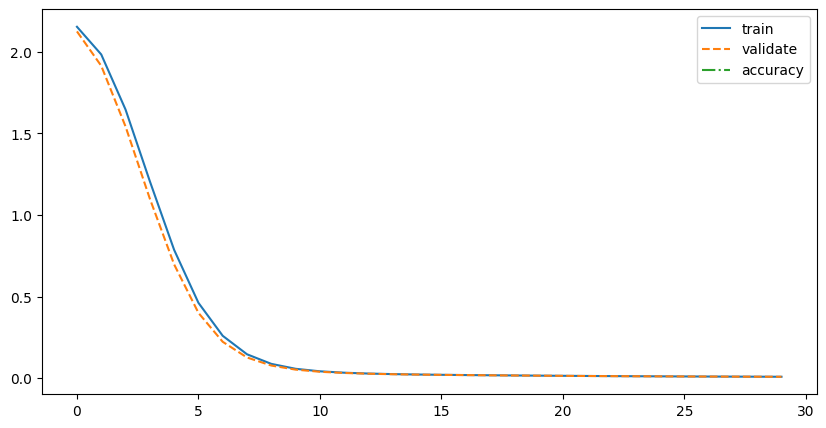

In [13]:
trainer.plot()

In [14]:
# Create a tensor of shape (2, 3) representing the predicted log probabilities
logits = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])

# Create a tensor of shape (2,) representing the target labels
labels = torch.tensor([0, 2])
F.cross_entropy(logits, labels)

tensor(1.4076)

In [20]:
from d2l_common import bleu
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']

preds, _ = model.predict_step(data.build(engs, fras), 'cpu', data.num_steps)
for en, fr, p in zip(engs,fras, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break
        translation.append(token)
    print(f'{en}=>{translation}, bleu,{bleu(" ".join(translation), fr, k=2):.3f}')

go .=>['soyez', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'], bleu,0.000
i lost .=>['soyez', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'], bleu,0.000
he's calm .=>['soyez', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'], bleu,0.000
i'm home .=>['soyez', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'], bleu,0.000


In [16]:
t0,t1 = torch.randn(2,3),torch.randn(2,3)
torch.cat((t0,t1),dim=-1)
torch.stack((t0,t1),dim=0), torch.stack((t0,t1),dim=1),torch.stack((t0,t1),dim=2).shape

(tensor([[[ 1.1904,  1.4663, -0.4575],
          [-0.9166, -0.7879,  1.0736]],
 
         [[-1.0710,  0.5600, -1.3072],
          [-1.4198, -0.3539, -1.3268]]]),
 tensor([[[ 1.1904,  1.4663, -0.4575],
          [-1.0710,  0.5600, -1.3072]],
 
         [[-0.9166, -0.7879,  1.0736],
          [-1.4198, -0.3539, -1.3268]]]),
 torch.Size([2, 3, 2]))

In [17]:
t0,t1 = torch.randn(2,3),torch.randn(2,3)
torch.cat((t0,t1),dim=-1)
t0,t1, torch.stack((t0,t1),dim=1),torch.stack((t0,t1),dim=2).shape

(tensor([[ 0.6261, -1.3500, -0.6899],
         [-0.6661, -0.1008, -0.6825]]),
 tensor([[-0.9924, -1.3781, -0.6864],
         [-0.8051, -0.6336, -1.8173]]),
 tensor([[[ 0.6261, -1.3500, -0.6899],
          [-0.9924, -1.3781, -0.6864]],
 
         [[-0.6661, -0.1008, -0.6825],
          [-0.8051, -0.6336, -1.8173]]]),
 torch.Size([2, 3, 2]))

In [18]:
import collections

def bleu(pred_seq, label_seq, k):
    """Compute the BLEU."""
    import math
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label/len_pred))
    # label_tokens=A,B,C,D,E,F
    # pred_tokens=A,B,B,C,D
    # len_pred=6, len_label=5
    for n in range(1, min(k, len_pred) + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[' '.join(label_tokens[i: i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[' '.join(pred_tokens[i: i + n])] > 0:
                num_matches += 1
                label_subs[' '.join(pred_tokens[i: i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score

In [19]:
bleu("A B B C D", "A B C D E F", 10)

0.0